<a href="https://colab.research.google.com/github/thehydrowave/Adversarial-diffusion-distillation-pokemon/blob/main/Addgood1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modèle Teacher

## 1. Importations et configuration de l'environnement

In [1]:
!pip install numpy==1.26.4 diffusers==0.25.1 transformers==4.37.2 accelerate==0.27.2 \
datasets==2.17.0 huggingface_hub==0.25.0 peft==0.7.1 fsspec==2023.6.0 \
torch==2.2.2 torchvision==0.17.2 pandas==2.2.2 --no-cache-dir --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 116.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 192.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 157.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 287.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 309.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 234.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 334.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 339.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Core Libraries
import numpy as np
from tqdm import tqdm
from PIL import Image

# PyTorch & Vision
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image

# Hugging Face Diffusers & Transformers
from diffusers import StableDiffusionPipeline
from diffusers.models.attention_processor import LoRAAttnProcessor, AttnProcessor
from transformers import CLIPTokenizer
from transformers import logging
logging.set_verbosity_error()  # Réduire les logs

# Datasets
from datasets import load_dataset, Dataset

# Affichage
from IPython.display import display
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## 2. Chargement du dataset Naruto + prétraitement



In [2]:
# Chargement du dataset personnalisé
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")

# Créer un dossier local pour les images
os.makedirs("naruto_images", exist_ok=True)

# Transformation : redimension + normalisation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # pour correspondre à SD
])

# Traitement du dataset
processed = []
for example in tqdm(dataset):
    image = example["image"].convert("RGB")
    image_tensor = transform(image)

    processed.append({
        "pixel_values": image_tensor,
        "text": example["text"]
    })

# Création du dataset Hugging Face
dataset_small = Dataset.from_list(processed)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

100%|██████████| 1221/1221 [00:40<00:00, 30.27it/s]


## 3. Chargement du modèle Stable Diffusion + test de génération

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

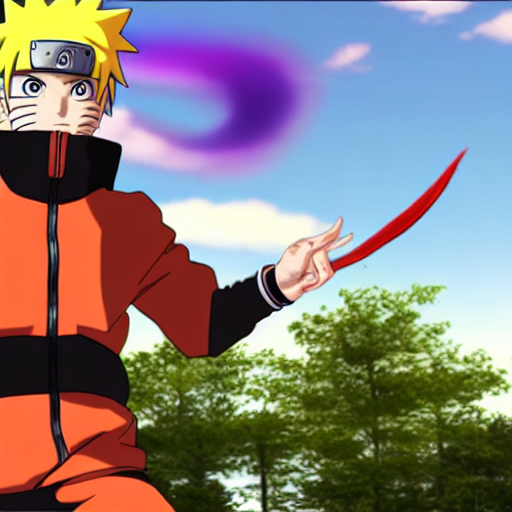

In [3]:
# Chargement du pipeline Stable Diffusion
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.to("cuda")
pipe.enable_attention_slicing()  # Réduction mémoire

tokenizer = pipe.tokenizer

# Test de génération d'image
prompt = "A Naruto character in a battle"
with torch.no_grad():
    result = pipe(prompt)
    image = result.images[0].convert("RGB")

display(image)

## 4. Préparation du DataLoader

In [4]:
def collate_fn(batch):
    images = torch.stack([
        torch.tensor(example["pixel_values"]) if not isinstance(example["pixel_values"], torch.Tensor) else example["pixel_values"]
        for example in batch
    ])
    prompts = [example["text"] for example in batch]

    inputs = tokenizer(
        prompts,
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

    return {
        "pixel_values": images,
        "input_ids": inputs.input_ids,
        "attention_mask": inputs.attention_mask,
    }

## 5. Création et vérification du DataLoader

Images shape: torch.Size([1, 3, 64, 64])
Input IDs shape: torch.Size([1, 64])


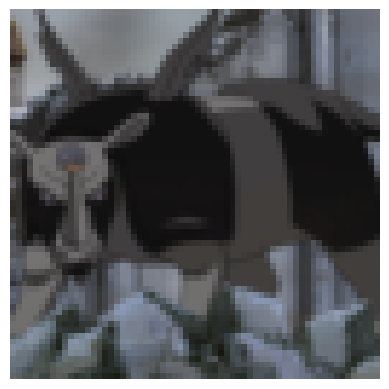

In [5]:
train_dataloader = DataLoader(
    dataset_small,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

# Vérification d’un batch
for batch in train_dataloader:
    print(f"Images shape: {batch['pixel_values'].shape}")
    print(f"Input IDs shape: {batch['input_ids'].shape}")

    # Affichage d'une image du batch
    img = batch["pixel_values"][0].permute(1, 2, 0)
    img = (img * 0.5 + 0.5).clamp(0, 1) # dénormaliser
    plt.imshow(img.cpu())
    plt.axis("off")
    plt.show()
    break

## 6. Application de LoRA (Low-Rank Adaptation)



In [6]:
# Récupérer la config des dimensions des layers
cross_attention_dim = pipe.unet.config.cross_attention_dim
attention_dims = {
    "mid_block": pipe.unet.config.block_out_channels[-1],
    "up_blocks.3": pipe.unet.config.block_out_channels[0],
    "up_blocks.2": pipe.unet.config.block_out_channels[1],
    "up_blocks.1": pipe.unet.config.block_out_channels[2],
    "up_blocks.0": pipe.unet.config.block_out_channels[3],
    "down_blocks.0": pipe.unet.config.block_out_channels[0],
    "down_blocks.1": pipe.unet.config.block_out_channels[1],
    "down_blocks.2": pipe.unet.config.block_out_channels[2],
    "down_blocks.3": pipe.unet.config.block_out_channels[3],
}

# Injecter les LoRA à la main
attn_processors = {}
for name, processor in pipe.unet.attn_processors.items():
    for block_key in attention_dims:
        if name.startswith(block_key):
            hidden_size = attention_dims[block_key]
            is_cross_attention = name.endswith("attn2.processor")

            attn_processors[name] = LoRAAttnProcessor(
                hidden_size=hidden_size,
                cross_attention_dim=cross_attention_dim if is_cross_attention else None
            )
            break
    else:
        # Ne pas modifier les autres
        attn_processors[name] = processor

pipe.unet.set_attn_processor(attn_processors)
print(f"LoRA manuellement appliqué à {sum(isinstance(p, LoRAAttnProcessor) for p in attn_processors.values())} couches.")

# Récupérer les poids LoRA entraînables
lora_params = []
for name, processor in pipe.unet.attn_processors.items():
    if isinstance(processor, LoRAAttnProcessor):
        for param in processor.parameters():
            param.requires_grad = True
            lora_params.append(param)

if not lora_params:
    raise ValueError("Toujours aucun poids LoRA détecté.")
else:
    print(f"Nombre total de paramètres LoRA : {sum(p.numel() for p in lora_params)}")

# Optimiseur
optimizer = torch.optim.Adam(lora_params, lr=1e-4)

LoRA manuellement appliqué à 0 couches.
Nombre total de paramètres LoRA : 797184


## 7. Boucle d'entraînement

In [29]:
# Nettoyage de la mémoire GPU
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Boucle d'entraînement
gradient_accumulation_steps = 4

for epoch in range(10):
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for step, batch in enumerate(loop):
        pixel_values = batch["pixel_values"].type(torch.float16).to("cuda")
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")

        noise = torch.randn_like(pixel_values)
        noised_images = pixel_values + noise

        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (pixel_values.shape[0],)).long().to("cuda").type(torch.float16)
        encoder_hidden_states = pipe.text_encoder(input_ids.to("cuda"))[0].type(torch.float16)

        noised_images = torch.cat([noised_images, torch.zeros_like(noised_images[:, :1, :, :])], dim=1)

        for param in pipe.unet.parameters():
            param.data = param.data.type(torch.float16)

        model_output = pipe.unet(noised_images, timesteps, encoder_hidden_states).sample
        loss = model_output.mean()
        loss = loss / gradient_accumulation_steps # Accumulate gradients
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
           optimizer.step()
           optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())

Epoch 9: 100%|██████████| 1221/1221 [07:27<00:00,  2.73it/s, loss=-0.00805]


## 8. Sauvegarde des poids LoRA

In [33]:
output_dir = "./naruto_weights"
os.makedirs(output_dir, exist_ok=True)

# On rassemble tous les poids LoRA des attn_processors
lora_state_dict = {}
for name, processor in pipe.unet.attn_processors.items():
    if isinstance(processor, LoRAAttnProcessor):
        for k, v in processor.state_dict().items():
            lora_state_dict[f"{name}.{k}"] = v

# Sauvegarde dans un seul fichier
torch.save(lora_state_dict, os.path.join(output_dir, "teacher_lora_weights.bin"))
print("Poids LoRA sauvegardés dans :", os.path.join(output_dir, "teacher_lora_weights.bin"))

Poids LoRA sauvegardés dans : ./naruto_weights/teacher_lora_weights.bin


## 9. Génération d'images Naruto avec le modèle LoRA sauvegardé

  0%|          | 0/50 [00:00<?, ?it/s]

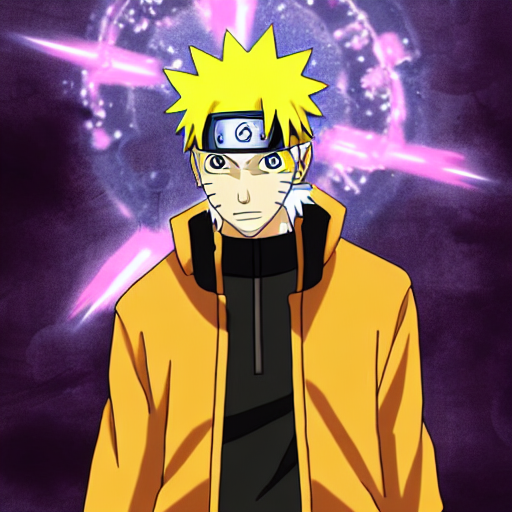

In [34]:
# Charger les poids LoRA sauvegardés une seule fois
lora_path = "./naruto_weights/teacher_lora_weights.bin"
lora_weights = torch.load(lora_path, map_location="cuda")

# Génération de l'image avec un prompt simple
prompt = "Naruto Uzumaki with a glowing aura"
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

# Affichage de l'image dans le notebook
display(image)